<a href="https://colab.research.google.com/github/dcolinmorgan/prediction/blob/master/tpu_LTRC_eth_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os,glob,gc
import pandas as pd
import numpy as np
from psutil import *
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import math,keras,time
import tensorflow as tf
# import cupy as cp

timestr = time.strftime("%Y%m%d")

check https://www.tensorflow.org/tutorials/structured_data/time_series

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ##CASE
## import tarfile
# t4data=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LTRCcase.npy'))

# # #CONTROL
# tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LTRCcontrol.npy'))

links=pd.read_csv('drive/My Drive/harvard/LARGE_COPD/LARGECOPD_links.txt',header=None,names=['TF','gene'])

# np.savez_compressed('drive/My Drive/harvard/LARGE_COPD/LTRC.npz', array1=t4data, array2=tdata)

data=np.load('drive/My Drive/harvard/LARGE_COPD/LTRC.npz')

t4data=pd.DataFrame(data['array1'])
t4data.columns=pd.read_csv('drive/My Drive/harvard/LARGE_COPD/LTRCcase_ages.txt',header=None)[0]

tdata=pd.DataFrame(data['array2'])
tdata.columns=pd.read_csv('drive/My Drive/harvard/LARGE_COPD/LTRCcontrol_ages.txt',header=None)[0]


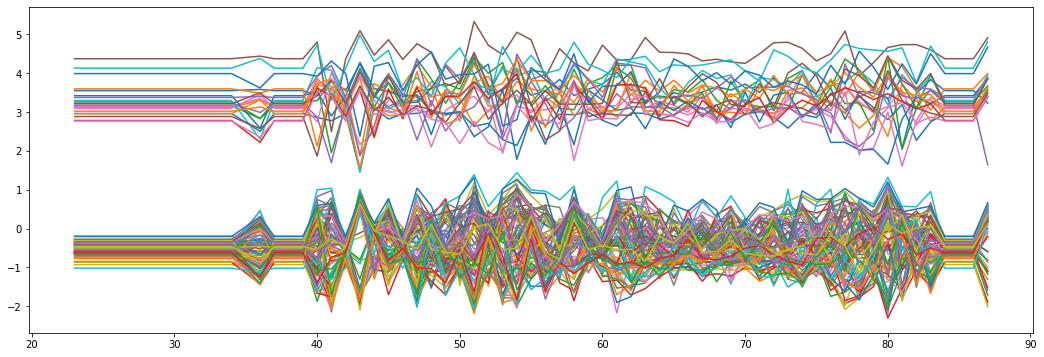

In [4]:
plt.figure(figsize=(18, 6))
w=plt.plot(tdata.T.iloc[:,1:100])

In [5]:
from scipy.stats import zscore
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset

# from keras.preprocessing import timeseries_dataset_from_array
# from keras.utils import plot_model
from keras.models import load_model

from keras import Sequential
from keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda,Dropout,Activation,RepeatVector,TimeDistributed
from keras.callbacks import EarlyStopping, LearningRateScheduler,ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
tf.keras.backend.clear_session()
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)


##look at data first, normalize

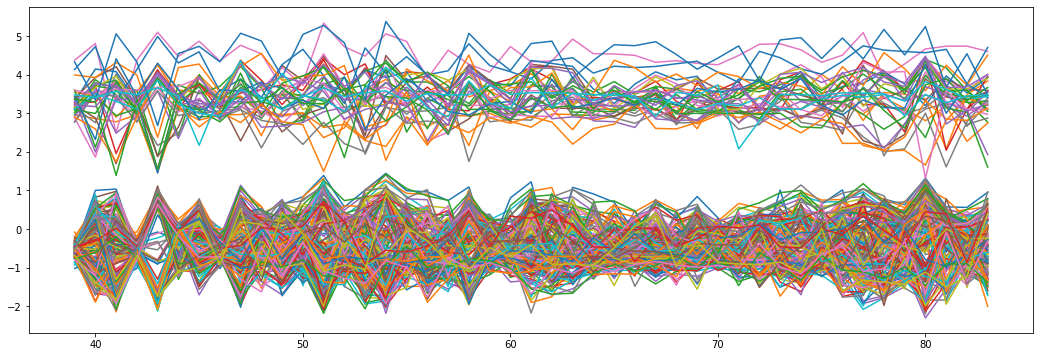

In [7]:
plt.figure(figsize=(18, 6))
w=plt.plot(tdata.T.iloc[8:53,0:200])

In [8]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

jj=np.random.choice(range(0,len(tdata)),size=20000,replace=False)
kk=np.random.choice(range(0,len(tdata)),size=20000,replace=False)

t2data = scaler.fit_transform(tdata.T.iloc[8:53,jj])#cont_gene_sum.iloc[:,10:50])) #r2data.iloc[:,10:50]))
t3data = scaler.fit_transform(tdata.T.iloc[8:53,kk])

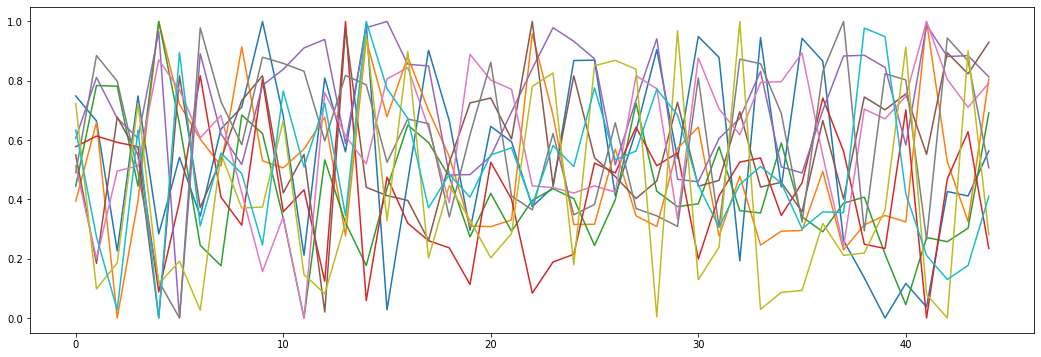

In [9]:
plt.figure(figsize=(18, 6))
w=plt.plot(pd.DataFrame(t2data).iloc[:,0:10])

In [10]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

jj=np.random.choice(range(0,len(t4data)),size=20000,replace=False)
kk=np.random.choice(range(0,len(t4data)),size=20000,replace=False)

t5data = scaler.fit_transform(t4data.T.iloc[8:53,jj])#cont_gene_sum.iloc[:,10:50])) #r2data.iloc[:,10:50]))
t6data = scaler.fit_transform(t4data.T.iloc[8:53,kk])

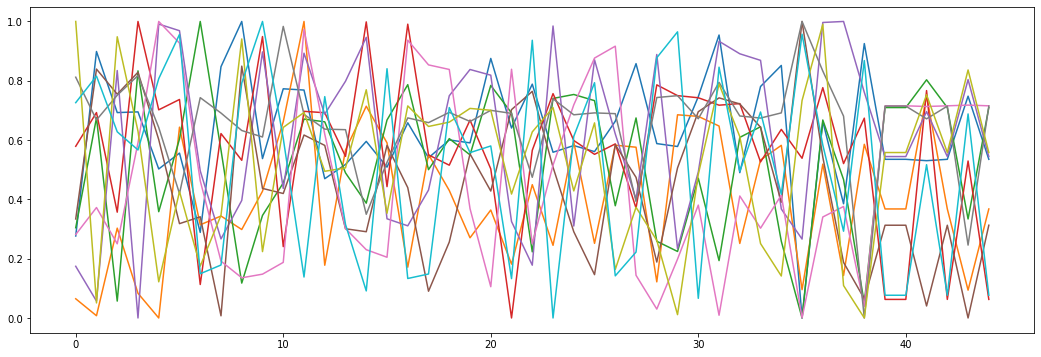

In [11]:
plt.figure(figsize=(18, 6))
w=plt.plot(pd.DataFrame(t5data).iloc[:,0:10])

## begin reworked model

[tutorial here](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)

In [12]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [13]:
dataset=t2data[:,0:200]

# choose a number of time steps
n_steps_in, n_steps_out = 40, 5
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print([X.shape,y.shape])
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]


[(1, 40, 200), (1, 5, 200)]


In [14]:
# ww=(dataset.T[8:53,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)])

# ww.shape
# x1_input=np.expand_dims(ww[0:40,:],axis=0)
# y1=np.expand_dims(ww[40:45,:],axis=0)
# print(x1_input.shape,y1.shape)
# X2, y2 = split_sequences(ww, n_steps_in, n_steps_out)
# zz=np.flip(ww,axis=0)
# print(y2,shape)

In [15]:
dataset=t5data[:,0:200]

# choose a number of time steps
n_steps_in, n_steps_out = 40, 5
# covert into input/output
X1, y1 = split_sequences(dataset, n_steps_in, n_steps_out)
print([X1.shape,y1.shape])
# the dataset knows the number of features, e.g. 2
n_features = X1.shape[2]

# strategy = tf.distribute.TPUStrategy(resolver)


[(1, 40, 200), (1, 5, 200)]


In [16]:
# define model (original)

with strategy.scope():
  model = Sequential()
  model.add(LSTM(2000, activation='relu', input_shape=(n_steps_in, n_features)))
  model.add(RepeatVector(n_steps_out))
  model.add((LSTM(2000,activation='relu',return_sequences=True)))
  # model.add(Bidirectional(LSTM(2000,activation='relu',return_sequences=True)))
  # model.add((LSTM(2000,activation='relu',return_sequences=True)))
  # model.add(Bidirectional(LSTM(2000,activation='relu',return_sequences=True)))
  # model.add((LSTM(2000,activation='relu',return_sequences=True)))

  # model.add((LSTM(2000,activation='relu',return_sequences=True))),
  # model.add(Activation('relu'))
  # model.add((LSTM(1024,activation='relu',return_sequences=True))),
  # model.add((LSTM(1024,activation='relu',return_sequences=True))),
  # model.add(LSTM(512, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(n_features)))
  model.compile(optimizer='adam', loss='mse')
  print(model.summary())


  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2000)              17608000  
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 2000)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 2000)           32008000  
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 200)            400200    
Total params: 50,016,200
Trainable params: 50,016,200
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X1, y1, epochs=200)#,verbose=0) ## swap training with X for X1 and back

model.save('~/drive/MyDrive/harvard/LARGE_COPD/model_output/case_tutorial_model_'+timestr+'.h5')
# plot_model(model, to_file='drive/MyDrive/LARGE_PANDA/model_output/420_tutorial_model_'+timestr+'.png', show_shapes=True)
# Image(filename='drive/MyDrive/LARGE_PANDA/model_output/420_tutorial_model_'+timestr+'.png')


In [30]:
from keras.models import load_model
# model = load_model('/content/drive/MyDrive/LARGE_PANDA/model_output/Cont_geneoutdegree_20210414-2043.h')
model = load_model('~/drive/MyDrive/harvard/LARGE_COPD/model_output/case_tutorial_model_'+timestr+'.h5')
# model=load_model('/content/drive/MyDrive/LARGE_PANDA/model_output/420_tutorial_model_20210421-1655.h5')
model.compile(loss='mse',
              experimental_steps_per_execution = 50,
              optimizer='adam',
              metrics=['mse'])

### predict

In [31]:
jeff=np.random.randint(99)
x_input = np.expand_dims(t2data[0:40,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)],axis=0) ## take next batch of links
yhat = model.predict(x_input, verbose=0)

x1_input = np.expand_dims(t5data[0:40,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)],axis=0) ## take next batch of links
y1hat = model.predict(x1_input, verbose=0)
print(jeff)

88


In [32]:
[X.shape,y.shape,yhat.shape]

[(1, 40, 200), (1, 5, 200), (1, 5, 200)]

In [33]:
trainScore = math.sqrt(mean_squared_error(yhat[0], y[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.37 RMSE


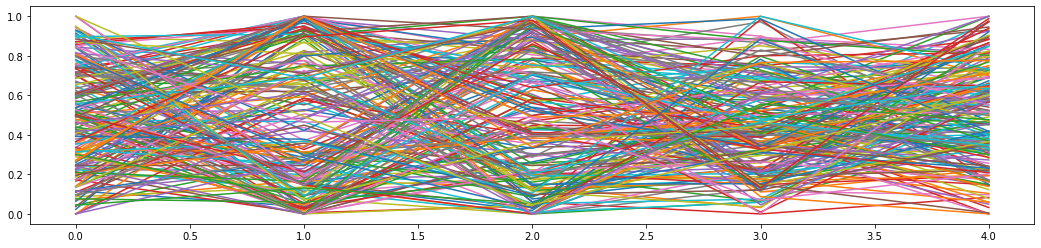

In [34]:
plt.figure(figsize=(18, 4))
c=plt.plot(y[0])

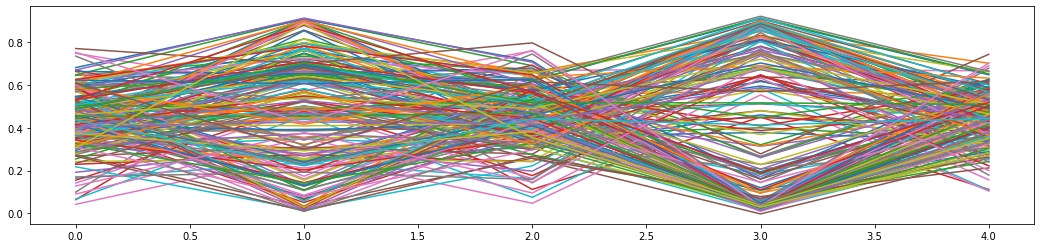

In [35]:
plt.figure(figsize=(18, 4))
c=plt.plot(yhat[0])

In [36]:
t2data[0:40,200:400].shape

(40, 200)

In [37]:
trainScore = math.sqrt(mean_squared_error(y1hat[0], y1[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.04 RMSE


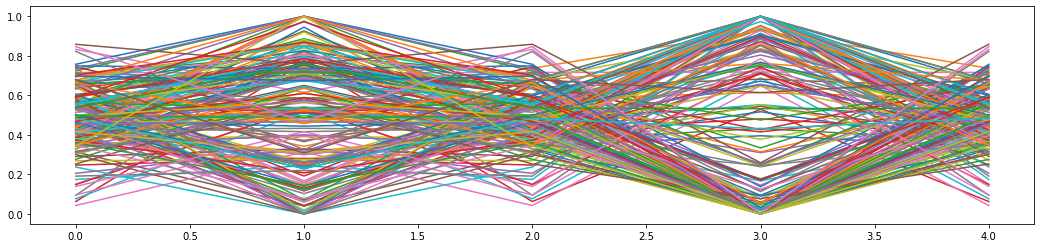

In [38]:
plt.figure(figsize=(18, 4))
c=plt.plot(y1[0])

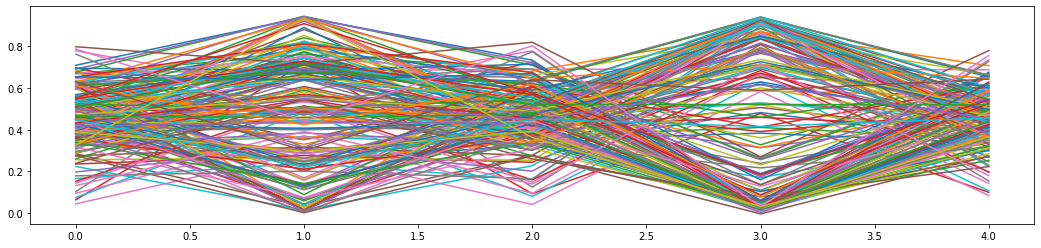

In [39]:
plt.figure(figsize=(18, 4))
c=plt.plot(y1hat[0])

In [42]:
dataset=t2data[:,0:200]

# choose a number of time steps
n_steps_in, n_steps_out = 40, 5
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print([X.shape,y.shape])

[(1, 40, 200), (1, 5, 200)]


In [82]:
# jeff=np.random.randint(99)
# ww=scaler.fit_transform(t4data.T.iloc[8:48,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)])
# ww=(t4data.T.iloc[8:53,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)])
ww=dataset
x1_input=np.expand_dims(ww[0:40,],axis=0)
y1=np.expand_dims(ww[40:45,:],axis=0)
# x1_input = np.expand_dims(dd,axis=0) ## take next batch of links
y1hat = model.predict(x1_input, verbose=0)
# print(jeff)

trainScore = math.sqrt(mean_squared_error(y1[0], y[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.00 RMSE


In [88]:
# ww=scaler.fit_transform(t5data.T[8:48,:])

ww=t5data
x2_input=np.expand_dims(ww[0:40,1:201],axis=0)
y2=np.expand_dims(ww[40:45,1:201],axis=0)

# x1_input = np.expand_dims(t5data[0:40,dataset.shape[1]*jeff:dataset.shape[1]*(jeff+1)],axis=0) ## take next batch of links
y2hat = model.predict(x2_input, verbose=0)

trainScore = math.sqrt(mean_squared_error(y2hat[0], y2[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.36 RMSE


In [77]:
t5data[0:40,].shape

(40, 20000)

In [72]:
t4data.shape

(8783160, 55)